
# RAG Lab: PDF → Chunking → Embeddings → ChromaDB 

In this lab you'll build a small Retrieval-Augmented Generation (RAG) data pipeline:
1. Load PDFs from a directory
2. Chunk the text using either **fixed-size** chunks with **overlap** or **LLM-assisted** segmentation
3. Embed the chunks with a compact Sentence-Transformers model
4. Store vectors and metadata in a local **ChromaDB** collection


### What you'll learn
- Why chunking and overlap improve recall
- How to choose and use an embedding model consistently
- How a local vector DB (ChromaDB) stores and retrieves embeddings

### Glossary (quick)
- **Chunk**: A small slice of text extracted from documents.
- **Overlap**: Repeating some tokens between adjacent chunks to avoid cutting important context.
- **Embedding**: A fixed-length vector representation of text.
- **Vector DB**: A database that stores vectors and supports similarity search (e.g., top-k retrieval).
- **Top-k retrieval**: Return the k most similar chunks to a query (nearest neighbors).


In [57]:
# ✅ Install minimal dependencies. If these are already installed, this cell is a no-op.
# !pip install langchain langchain-community pypdf chromadb sentence-transformers transformers tqdm --quiet

In [ ]:

# ---- Imports & configuration ----
import os, re, uuid, glob, math, json
from pathlib import Path
from typing import List, Dict, Any, Optional
from dataclasses import dataclass

import numpy as np
import pandas as pd
from tqdm import tqdm
import fitz  # PyMuPDF

# Embeddings
from sentence_transformers import SentenceTransformer

# --- Student-editable configuration ---
PDF_DIR = "./pdfs"                  # directory with source PDFs
PERSIST_DIR = "./rag_chroma"        # ChromaDB persistence path (folder will be created)
COLLECTION_NAME = "cnu_rag_lab"     # collection name
CHUNK_WORDS = 400                   # fixed-size chunk length (~words)
CHUNK_OVERLAP_WORDS = 40            # overlap between chunks (~words)
EMBED_MODEL_NAME = "sentence-transformers/msmarco-distilbert-cos-v5"
USE_LLM_CHUNKING = False            # set True to try optional LLM-assisted chunking
MAX_PAGES_PER_PDF: Optional[int] = None  # set an int (e.g., 5) to limit pages for demos

# Sanity: ensure dirs exist
Path(PDF_DIR).mkdir(parents=True, exist_ok=True)
Path(PERSIST_DIR).mkdir(parents=True, exist_ok=True)


In [ ]:
# how many tokens can my model take (context window size)?
embedder = SentenceTransformer(EMBED_MODEL_NAME)
max_tokens_for_model=embedder.max_seq_length

# Estimate character count based on average token-to-character ratio (e.g., 4 characters per token)
# This is an approximation; precise tokenization depends on the model's tokenizer.

estimated_max_chars = max_tokens_for_model * 4
# estimated_max_chars = 500

print(f"Embedding model: {EMBED_MODEL_NAME}, max context tokens={max_tokens_for_model}, estimated max characters={estimated_max_chars}")    

del embedder
embedder=None

# Run GC and release common GPU framework caches
import gc
gc.collect()

# PyTorch
import torch
try:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
except Exception:
    pass


Embedding model: sentence-transformers/msmarco-distilbert-cos-v5, max context tokens=384, estimated max characters=1536



## 1) Load PDFs

We'll extract text with **PyMuPDF** page-by-page. Empty or whitespace-only pages are dropped.  
**Why this matters:** We want a clean, normalized text corpus before chunking to ensure consistent chunk lengths and quality.


In [5]:
from langchain_community.document_loaders import PyPDFLoader
import glob

pages = []
pdf_files = glob.glob(os.path.join(PDF_DIR, "*.pdf"))
for pdf_path in pdf_files:
    loader = PyPDFLoader(pdf_path)
    pages.extend(loader.load())
print(f"Number pdf pages loaded={len(pages)}")
pages[0]

Number pdf pages loaded=315


Document(metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 20.4 (Windows)', 'creationdate': '2025-07-29T14:06:32-04:00', 'moddate': '2025-07-30T09:22:09-04:00', 'title': 'Christopher Newport University: Undergraduate Catalog 2019-20', 'trapped': '/False', 'source': './pdfs/2025-26-undergraduate_catalog.pdf', 'total_pages': 315, 'page': 0, 'page_label': '1'}, page_content='Undergraduate Catalog \nV olume 60, Number 1, July 2025 \nThe provisions of this catalog do not constitute a contract, expressed or implied, between any applicant or student and the \nRector and Board of Visitors of Christopher Newport University. The University reserves the right to change any of the provi-\nsions, schedules, programs, courses, rules, regulations, or fees whenever the University deems it expedient to do so. \nChristopher Newport University is committed to providing an environment that emphasizes the dignity and worth of every \nmember of its community and that is free from ha


## 2) Chunking (Fixed-Size with Overlap)

We'll implement a tokenizer-free word splitter and then slide a window with overlap.  
**Why overlap?** It preserves context that may straddle chunk boundaries, improving recall during retrieval.

BTW this is subtle and hardish to get right, maybe split just on paragraphs, that will get each class description as a single paragraph.

(gemini summary):A good starting chunk size for RAG is typically 128 to 512 tokens, but the ideal size depends on your specific data, the retriever model, and the task. Smaller chunks (e.g., 128-256 tokens) are better for factual, keyword-based queries, while larger chunks (e.g., 256-512 tokens) capture broader context needed for summarizing concepts. You should also consider the embedding model's context window (e.g., if it supports 512 tokens, don't chunk larger) and experiment with overlapping chunks to preserve context. 


**Factors to Consider**

**Query Type:**

<u>Fact-based queries:</u>benefit from smaller chunks (e.g., 128-256 tokens) to pinpoint specific facts and improve retrieval accuracy. 


<u>Contextual or summarization queries:</u> require larger chunks (e.g., 256-512 tokens) to provide broader context and retain meaningful information. 


In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=estimated_max_chars,  # Set chunk size in characters (~4 chars per token*tokens for modelcontext window)
    chunk_overlap=200,  # Overlap between chunks (in characters)
    separators=["\n\n", "\n", "(?<=\. )"]
)

In [7]:
#how many chunks
chunks=r_splitter.split_documents(pages)
print(f"Generated {len(chunks)} chunks")

Generated 1239 chunks


In [8]:
#strip out beginning and ending whitespace
for chunk in chunks:
    chunk.page_content = chunk.page_content.strip()

### Look what is inside each chunk, note the amount of information in the metadata field

In [9]:
# Display all attributes of a particular chunk
chunk_numb=5
print("Type:", type(chunks[chunk_numb]))
print("\nPage Content:")
print(chunks[chunk_numb].page_content)

print("\nMetadata:")
print(chunks[chunk_numb].metadata)
print("\nMetadata:Page")
print(chunks[chunk_numb].metadata['page'])

print("\nAll attributes:")
print(dir(chunks[chunk_numb]))

Type: <class 'langchain_core.documents.base.Document'>

Page Content:
tion. We rank as one of the safest campuses in Virginia and 
pride ourselves on investing in our infrastructure to provide 
opportunities for all. We have completed $1 billion in new 
capital construction, including: 
• A new Science and Engineering Research Center is 
under construction and will feature a two-story drone 
lab, maker space, and state-of-the-art demonstration 
classroom. 
• Stellar academic halls. McMurran Hall is home to 
our superb liberal arts programs. Forbes Hall, our 
integrated science center, provides a 21st-century 
hub for education and discovery. Luter Hall houses 
the Luter School of Business; Economics; Sociol -
ogy, Social Work and Anthropology; Leadership and 
American Studies; Mathematics; and the School of 
Engineering and Computing. 
• The Mary M. Torggler Fine Arts Center is a stun-
ning new addition to campus. Graced by an entry 
rotunda of cascading glass domes, the Torggler fea -

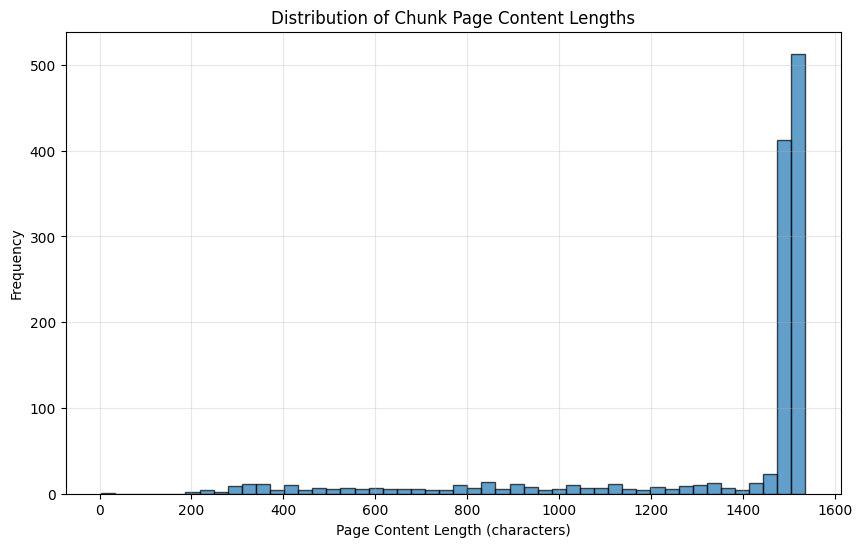

Total chunks: 1239
Min length: 3
Max length: 1535
Average length: 1352.52


In [10]:
import matplotlib.pyplot as plt

# Calculate the length of page_content for each chunk
chunk_lengths = [len(chunk.page_content) for chunk in chunks]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(chunk_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Page Content Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Page Content Lengths')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total chunks: {len(chunk_lengths)}")
print(f"Min length: {min(chunk_lengths)}")
print(f"Max length: {max(chunk_lengths)}")
print(f"Average length: {sum(chunk_lengths)/len(chunk_lengths):.2f}")


### <mark>IMPORTANT! Make sure your max page_content chunk size is <= your embedding models max token context window. (Approximated by 1 token ~ 4 chars here)


## 3) Optional: LLM-Assisted Chunking (Semantic Segmentation)

**Idea:** Ask an LLM to segment a page into coherent sections (headings, paragraphs, lists). Then, for any very long segments, re-chunk using the fixed method above so that chunks stay small.

> This path is **optional** and requires an API key. If you set `USE_LLM_CHUNKING = True`, make sure `OPENAI_API_KEY` is in your environment. Keep your key private.


In [11]:

# def llm_segment_page(text: str, model: str = "gpt-4o-mini") -> List[str]:
#     '''
#     Use an LLM to segment the page text into coherent sections.
#     Returns a list of segments. On any error or short text, returns [text].
#     '''
#     text = text.strip()
#     if len(text.split()) < 80:
#         return [text]
#     try:
#         import os
#         api_key = os.getenv("OPENAI_API_KEY")
#         if not api_key:
#             # No key -> no network call; just fall back gracefully
#             return [text]

#         # Install only if needed
#         try:
#             from openai import OpenAI  # modern SDK
#         except Exception:
#             import sys
#             print("[INFO] Installing openai client...")
#             !{sys.executable} -m pip -q install --upgrade openai
#             from openai import OpenAI

#         client = OpenAI(api_key=api_key)

#         prompt = (
#             "You segment text into coherent sections such as headings and paragraphs. "
#             "Return a JSON list of strings where each string is a segment. "
#             "Keep segments between 150-400 words when possible.\n\n"
#             f"TEXT:\n{text[:8000]}"
#         )
#         resp = client.responses.create(
#             model=model,
#             input=[{"role":"user","content":prompt}],
#             response_format={"type":"json_object"}
#         )
#         # Extract JSON safely
#         content = resp.output[0].content[0].text  # SDK shapes can vary; adjust if needed
#         import json as _json
#         parsed = _json.loads(content)
#         segments = parsed.get("segments") or parsed.get("data") or parsed.get("list")
#         if isinstance(segments, list) and all(isinstance(s, str) for s in segments):
#             # light cleanup
#             segments = [s.strip() for s in segments if s.strip()]
#             return segments or [text]
#         return [text]
#     except Exception as e:
#         # Silent, robust fallback
#         return [text]

# def rechunk_if_long(segments: List[str], max_words: int = 600) -> List[str]:
#     '''If a segment is too long, re-chunk with the fixed method to keep sizes bounded.'''
#     out = []
#     for s in segments:
#         if len(words(s)) > max_words:
#             out.extend(chunk_fixed(s, CHUNK_WORDS, CHUNK_OVERLAP_WORDS))
#         else:
#             out.append(s)
#     return out

# def chunk_pages_llm(page_records: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
#     '''
#     Segment each page via LLM, then bound segment length. Tag method='llm'.
#     Requires OPENAI_API_KEY for actual LLM calls; otherwise falls back implicitly.
#     '''
#     out = []
#     for rec in tqdm(page_records, desc="LLM segmenting pages"):
#         segs = llm_segment_page(rec["text"])
#         segs = rechunk_if_long(segs, max_words=600)
#         for s in segs:
#             out.append({
#                 "chunk_id": str(uuid.uuid4()),
#                 "doc_id": rec["doc_id"],
#                 "source": rec["source"],
#                 "page": rec["page"],
#                 "method": "llm",
#                 "text": s
#             })
#     return out

# chunk_records_llm = chunk_pages_llm(pages) if (pages and USE_LLM_CHUNKING) else []
# print(f"LLM-assisted path produced {len(chunk_records_llm)} chunks (0 if not enabled).")


## 4) Gather the data that goes into a VectorDB

In [ ]:
sources=[chunk.metadata['source'] for chunk in chunks]
pages=[chunk.metadata['page'] for chunk in chunks]
metadatas=[{"source": sources[i],
            "page": pages[i]} for i in range(len(chunks))]
ids=[str(i) for i in range(len(chunks))]
documents=[chunk.page_content for chunk in chunks]

# print(len(documents))
# print(documents[0] )


## 5) Embeddings



### Semantic Search

Semantic search seeks to improve search accuracy by understanding the semantic meaning of the search query and the corpus to search over. Semantic search can also perform well given synonyms, abbreviations, and misspellings, unlike keyword search engines that can only find documents based on lexical matches.

### Background

The idea behind semantic search is to embed all entries in your corpus, whether they be sentences, paragraphs, or documents, into a vector space. At search time, the query is embedded into the same vector space and the closest embeddings from your corpus are found. These entries should have a high semantic similarity with the query.

![SemanticSearch](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/SemanticSearch.png)

### Symmetric vs. Asymmetric Semantic Search

A **critical distinction** for your setup is *symmetric* vs. *asymmetric semantic search*:

- For **symmetric semantic search** your query and the entries in your corpus are of about the same length and have the same amount of content. An example would be searching for similar questions: Your query could for example be *"How to learn Python online?"* and you want to find an entry like *"How to learn Python on the web?"*. For symmetric tasks, you could potentially flip the query and the entries in your corpus.
  - Related training example: [Quora Duplicate Questions](../../training/quora_duplicate_questions/README.md).
  - Suitable models: [Pre-Trained Sentence Embedding Models](../../../../docs/sentence_transformer/pretrained_models.md)
- For **asymmetric semantic search**, you usually have a **short query** (like a question or some keywords) and you want to find a longer paragraph answering the query. An example would be a query like *"What is Python"* and you want to find the paragraph *"Python is an interpreted, high-level and general-purpose programming language. Python's design philosophy ..."*. For asymmetric tasks, flipping the query and the entries in your corpus usually does not make sense.
  - Related training example: [MS MARCO](../../training/ms_marco/README.md)
  - Suitable models: [Pre-Trained MS MARCO Models](../../../../docs/pretrained-models/msmarco-v5.md)

It is critical **that you choose the right model** for your type of task.

```{eval-rst}
.. tip::

    For asymmetric semantic search, you are recommended to use :meth:`SentenceTransformer.encode_query <sentence_transformers.SentenceTransformer.encode_query>` to encode your queries and :meth:`SentenceTransformer.encode_document <sentence_transformers.SentenceTransformer.encode_document>` to encode your corpus. 
    
    
```

In [ ]:
# Load the embedder
embedder = SentenceTransformer(EMBED_MODEL_NAME)
print("Embedding model loaded:", EMBED_MODEL_NAME)

#encode in batches
batch_size = 64
embeddings = []
for i in tqdm(range(0, len(chunks), batch_size), desc="Embedding chunks"):
    # batch_texts = df['text'].iloc[i:i+batch_size].tolist()
    batch_texts=documents[i:i+batch_size]
    
    #if using sentence transformer use encode_document to embed your corpus
    batch_vecs = embedder.encode_document(batch_texts, batch_size=min(32, len(batch_texts)), show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
    embeddings.append(batch_vecs)

print("Embeddings shape:", len(embeddings[0]))
embeddings = np.vstack(embeddings).astype("float32")
print("Embeddings shape:", embeddings.shape)

Embedding model loaded: sentence-transformers/msmarco-distilbert-cos-v5



## 5) ChromaDB: Create / Persist Collection

We'll use a **PersistentClient** so your vectors survive across sessions in `PERSIST_DIR`.  
**Why this matters:** Persistence lets you build once and query many times.


In [ ]:
import chromadb

# Persistent client that will store the data
client = chromadb.PersistentClient(path=PERSIST_DIR)

try:
    # Delete the collection if it exists
    client.delete_collection(name=COLLECTION_NAME)
    print(f"Collection '{COLLECTION_NAME}' deleted successfully.")
except Exception as e:
    print(f"Error deleting collection '{COLLECTION_NAME}': {e}")

collection = client.create_collection(
    name=COLLECTION_NAME,
    metadata={"hnsw:space": "cosine"},
    embedding_function=None)


Collection 'cnu_rag_lab' deleted successfully.


### Push all content to the vector DB

Note the expected inputs

In [17]:
# Upsert (safe to re-run)
collection.upsert(
    ids=ids,   
    embeddings=embeddings,
    metadatas=metadatas,
    documents=documents
)
print(f"Collection '{COLLECTION_NAME}' now has {collection.count()} vectors. Persisted at: {PERSIST_DIR}")


Collection 'cnu_rag_lab' now has 1239 vectors. Persisted at: ./rag_chroma


In [18]:
# Access the configuration to find the distance metric (space)
print(f"The distance metric is: {collection.metadata.get('hnsw:space') }")


The distance metric is: cosine



## 6) Retrieval: Top‑k Nearest Chunks

We'll embed the user query with the **same model** and query ChromaDB for the nearest chunks.


In [50]:
import pandas as pd
def embed_query(q: str) -> np.ndarray:
    '''Embed a query string using the same SentenceTransformer model (normalized).'''
    # For asymmetric semantic search, you are recommended to use SentenceTransformer.encode_query to encode your queries
    v = embedder.encode_query([q], convert_to_numpy=True, normalize_embeddings=True)
    return v[0].astype("float32")

def query_topk(question: str, k: int = 5) -> pd.DataFrame:
    '''Return a pretty DataFrame with rank, distance (smaller is closer), and metadata.'''
    q_emb = embed_query(question)

    res = collection.query(
        query_embeddings=[q_emb],
        n_results=k,
        include=["documents", "metadatas", "distances"]
    )

    # Flatten results
    rows = []
    for rank, (cid, dist, meta, doc) in enumerate(zip(res["ids"][0], res["distances"][0], res["metadatas"][0], res["documents"][0]), start=1):
        rows.append({
            "rank": rank,
            "distance": round(float(dist), 4),
            "source": meta.get("source"),
            "page": meta.get("page"),
            "chunk_id": cid,
            "snippet": doc
        })
    out = pd.DataFrame(rows)
    return out

# Try a query (edit this to your corpus):
example_queries = [
    "What are the pre reqs for CPSC 475",
    "What are the key definitions introduced?",
    "List the steps or procedures mentioned in the text."
]
print("Try:", example_queries[0])
res_df = query_topk(example_queries[0], k=40)
res_df
# head(res_df, 20)

Try: What are the pre reqs for CPSC 475


,rank,distance,source,page,chunk_id,snippet
0,1,0.5774,./pdfs/2025-26-undergraduate_catalog.pdf,272,1073,CPSC 250. Programming for Data Manipulation (3...
1,2,0.5801,./pdfs/2025-26-undergraduate_catalog.pdf,267,1051,"7. CPSC 150/150L-250/250L, 255, 270, 327, 410,..."
2,3,0.5943,./pdfs/2025-26-undergraduate_catalog.pdf,272,1071,"puter terminology, hardware and software organ..."
3,4,0.6031,./pdfs/2025-26-undergraduate_catalog.pdf,271,1068,"developed, which involves considerations and d..."
4,5,0.6110,./pdfs/2025-26-undergraduate_catalog.pdf,274,1078,275 \n \n \n \n \n \n \n \n \n \n \n \...
5,6,0.6245,./pdfs/2025-26-undergraduate_catalog.pdf,274,1080,School of Engineering and Computing \nment app...
6,7,0.6352,./pdfs/2025-26-undergraduate_catalog.pdf,274,1079,out of the system’s model and its computer sol...
7,8,0.6354,./pdfs/2025-26-undergraduate_catalog.pdf,272,1072,"selection and iterative statements, defining a..."
8,9,0.6427,./pdfs/2025-26-undergraduate_catalog.pdf,273,1076,"including computer micro-operations, control o..."
9,10,0.6648,./pdfs/2025-26-undergraduate_catalog.pdf,273,1077,goals and needs to determine and specify infor...


## Use a reranker to rerank the selected chunks

Many fewer comparisons (just the results returned from the bi encoder). 

In [51]:
#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-electra-base')
scores=[]
for i in range(len(res_df)):
    scores.append(model.predict([[example_queries[0], res_df.iloc[i]['snippet']]]).item())

scores

[0.11808445304632187,
 0.16492779552936554,
 0.12231894582509995,
 0.23019930720329285,
 0.6566240787506104,
 0.9925817251205444,
 0.9903662204742432,
 0.0744319036602974,
 0.04540009796619415,
 0.10857606679201126,
 0.04426323249936104,
 0.7230622172355652,
 0.0017515078652650118,
 0.9824444651603699,
 0.010622018948197365,
 0.17793092131614685,
 0.000783714756835252,
 3.907837162842043e-05,
 0.0003623896336648613,
 0.00015945649647619575,
 0.9918255805969238,
 5.756693644798361e-05,
 0.8962242603302002,
 0.044821154326200485,
 0.9133202433586121,
 0.0010588826844468713,
 0.0001055396132869646,
 0.001109914854168892,
 3.782376370509155e-05,
 0.00012470045476220548,
 3.205974280717783e-05,
 0.10841655731201172,
 0.841745138168335,
 0.0002226013457402587,
 0.057175979018211365,
 0.026292186230421066,
 0.0018969923257827759,
 0.00014367641415446997,
 0.00033200293546542525,
 0.0005895309732295573]

In [54]:
#add scores to dataframe
res_df['cross_encoder_score'] = pd.Series(scores)

#for cross-encoders, higher scores are better, as they indicate a higher degree of relevance or similarity between the query and the document pair. 
res_df = res_df.sort_values(by='cross_encoder_score', ascending=False)

res_df

,rank,distance,source,page,chunk_id,snippet,cross_encoder_score
5,6,0.6245,./pdfs/2025-26-undergraduate_catalog.pdf,274,1080,School of Engineering and Computing \nment app...,0.992582
20,21,0.6938,./pdfs/2025-26-undergraduate_catalog.pdf,274,1081,"representations, rigid body transforms in 2D a...",0.991826
6,7,0.6352,./pdfs/2025-26-undergraduate_catalog.pdf,274,1079,out of the system’s model and its computer sol...,0.990366
13,14,0.6737,./pdfs/2025-26-undergraduate_catalog.pdf,271,1069,"implementation, micro-programmable controllers...",0.982444
24,25,0.7041,./pdfs/2025-26-undergraduate_catalog.pdf,270,1062,"degree, it does not require the second science...",0.913320
22,23,0.6981,./pdfs/2025-26-undergraduate_catalog.pdf,275,1082,276 \n \n \n \n \n \n \n \n \n \n \n ...,0.896224
32,33,0.7188,./pdfs/2025-26-undergraduate_catalog.pdf,78,298,Public Accounting (CPA) exam is comprised of t...,0.841745
11,12,0.6674,./pdfs/2025-26-undergraduate_catalog.pdf,273,1075,Pre or Corequisite: ENGR 213. \nStudy of objec...,0.723062
4,5,0.6110,./pdfs/2025-26-undergraduate_catalog.pdf,274,1078,275 \n \n \n \n \n \n \n \n \n \n \n \...,0.656624
3,4,0.6031,./pdfs/2025-26-undergraduate_catalog.pdf,271,1068,"developed, which involves considerations and d...",0.230199


In [20]:
res_df.iloc[0]['snippet']

'CPSC 250. Programming for Data Manipulation (3-3-0) \nPrerequisites: Grade of C- or higher in CPSC 150/150L \nCorequisites: CPSC 250L and MATH 135 or 140 or 148 or \npermission of department chair \nThis course builds upon concepts taught in CP…'

In [29]:
# Query the collection to retrieve the chunk with chunk_id=1695  all-MiniLM-L6-v2
result = collection.get(
    ids=["1081"],
    include=["documents", "metadatas"]
)

# Display the resultb
if result['ids']:
    print(f"Chunk ID: {result['ids'][0]}")
    print(f"\nMetadata: {result['metadatas'][0]}")
    print(f"\nDocument Content:\n{result['documents'][0]}")
else:
    print("Chunk with ID 1695 not found.")

Chunk ID: 1081

Metadata: {'source': './pdfs/2025-26-undergraduate_catalog.pdf', 'page': 274}

Document Content:
representations, rigid body transforms in 2D and 3D, robot 
kinematics, basic control theory, motion planning, percep -
tion and machine decision making. Perception topics include 
basic computer vision and laser rangefinder (LIDAR)-based 
obstacle detection and mapping. The course includes hands 
on development and system integration using various robotic 
platforms. Programming will be done in Ubuntu Linux in a 
mixture of C++ and Python; no prior experience is required, 
but students will be expected to self-teach the specifics neces-
sary to complete the projects. 
CPSC 475. Android Mobile Computing (3-3-0) 
Prerequisite: CPSC 255 with a grade of C- or higher. 
This course covers core concepts of the Android program -
ming platform and its key components using the Android 
SDK and the Java programming language. Topics discussed 
include application lifecycle, user interf

In [22]:
selected_wrong_embedding=res_df.iloc[0]['snippet']
correct_emb=embedder.encode([chunks[0].page_content], convert_to_numpy=True, normalize_embeddings=True)
query_emb=embedder.encode([example_queries[0]], convert_to_numpy=True, normalize_embeddings=True)

from sklearn.metrics.pairwise import cosine_similarity

print(f"between query and correct embedding: {cosine_similarity(query_emb, correct_emb)}")
print(f"between query and selected wrong embedding: {cosine_similarity(query_emb, embedder.encode([selected_wrong_embedding], convert_to_numpy=True, normalize_embeddings=True))}")

between query and correct embedding: [[0.06060335]]
between query and selected wrong embedding: [[0.41863543]]


In [23]:
q1="I like yummy beans"
q2="I enjoy tasty legumes"
q1_emb=embedder.encode([q1], convert_to_numpy=True, normalize_embeddings=True)
q2_emb=embedder.encode([q2], convert_to_numpy=True, normalize_embeddings=True)
cosine_similarity(q1_emb, q2_emb)

array([[0.50056314]], dtype=float32)

In [24]:
res = collection.query(
        query_embeddings=query_emb,
        n_results=3,
        include=["documents", "metadatas", "distances"]
    )
res

{'ids': [['1073', '1051', '1071']],
 'embeddings': None,
 'documents': [['CPSC 250. Programming for Data Manipulation (3-3-0) \nPrerequisites: Grade of C- or higher in CPSC 150/150L \nCorequisites: CPSC 250L and MATH 135 or 140 or 148 or \npermission of department chair \nThis course builds upon concepts taught in CPSC 150 and \nprovides continuing study of data storage and manipulation, \nand introduces their application to scientific computing and \nvisualization. Specific topics include object oriented design, \nprogramming style, debugging and algorithm design. The \ncourse will incorporate the use of existing libraries for data \nprocessing and visualization. \nCPSC 250L. Programming for Data Manipulation \nLaboratory (1-0-3) \nPrerequisites: CPSC 150/150L with a grade of C- or \nhigher. \nPre or Corequisite: CPSC 250. \nLaboratory course supports the concepts in CPSC 250 lecture \nwith hands-on programming activities and language specific \nimplementation. Laboratory exercises st

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
query_emb.shape

(1, 768)


## 7) Mini‑RAG: Concise Answer Synthesis (Optional)

If you have an API key in your environment (`OPENAI_API_KEY`), we can ask a model for a **short, grounded** answer. Otherwise, we'll just show the retrieved context.


In [27]:

def build_context(df_hits: pd.DataFrame) -> str:
    ctx_lines = []
    for _, row in df_hits.iterrows():
        ctx_lines.append(f"[{row['source']} p.{row['page']} | {row['method']}] {row['snippet']}")
    return "\n".join(ctx_lines)

def synthesize_answer(question: str, topk: int = 5, model: str = "gpt-4o-mini") -> None:
    hits = query_topk(question, k=topk)
    ctx = build_context(hits)
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        print("No OPENAI_API_KEY found. Showing retrieved context instead:\n")
        print(ctx)
        return
    try:
        from openai import OpenAI
    except Exception:
        import sys
        print("[INFO] Installing openai client...")
        !{sys.executable} -m pip -q install --upgrade openai
        from openai import OpenAI

    client = OpenAI(api_key=api_key)

    sys_prompt = "You are a concise teaching assistant. Answer only using the provided evidence. Cite filename and page."
    user_prompt = f"Question: {question}\n\nEvidence:\n{ctx}\n\nIf insufficient, say you don't know."
    try:
        resp = client.responses.create(model=model, input=[
            {"role":"system","content":sys_prompt},
            {"role":"user","content":user_prompt}
        ])
        answer = resp.output_text if hasattr(resp, "output_text") else str(resp)
        print(answer.strip())
    except Exception as e:
        print("LLM call failed; printing context instead.\nReason:", e)
        print(ctx)

# Example (uncomment to try):
# synthesize_answer("What problem does this document address?", topk=5)



## 8) Sanity Checks & Simple Stats

Quick checks to ensure counts and shapes look reasonable.


In [28]:

def chunk_word_count(s: str) -> int:
    return len(words(s))

stats = df["text"].apply(chunk_word_count).describe()
print("Chunk length (words) stats:\n", stats.to_string())

print("\nVectors in collection:", collection.count())
print("Unique docs:", df["doc_id"].nunique())
print("Chunking method(s):", df["method"].value_counts().to_dict())


NameError: name 'df' is not defined


## 9) Wrap‑Up & Next Steps

**Key takeaways**
- Fixed-size chunks with overlap are simple and reliable; LLM-assisted segmentation can yield cleaner semantic boundaries but requires an API key and careful prompting.
- Use the **same** embedding model for both documents and queries.
- Persisting to ChromaDB allows fast iteration without re-embedding every run.

**Try next**
- Tune `CHUNK_WORDS`/`CHUNK_OVERLAP_WORDS`.
- Swap the embedder: e.g., `"BAAI/bge-small-en-v1.5"` (remember to re-embed queries too).
- Add a reranker (e.g., cross-encoder) to re-order top-k hits before synthesis.
- Track sources when synthesizing answers (we included filename + page).

Happy building! 🎓
